# Estimating taxi fares

In [24]:
import google.datalab.bigquery as bq
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
import itertools
import tensorflow as tf
from tensorflow.contrib import layers
import tensorflow.contrib.learn as tflearn
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
from google.datalab.ml import TensorBoard

In this exercise we analyse a data set consisting of taxi ride data. 

The full data set is 1,108,779,463 rows (130GB) and is obtained from the Google BigQuery package of example datasets. 

We start by writing a basic query to pull a set of rows. The `FARM_FINGERPRINT` hash function allows us to sample a set of rows which will be consistent each time the query is run. 

In [2]:
rawdata="""
SELECT
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  `nyc-tlc.yellow.trips`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),EVERY_N) = 1
"""

In [3]:
query=rawdata.replace("EVERY_N", "100000")
trips = bq.Query(query).execute().result().to_dataframe()
print "Our sample dataset consists of {} taxi rides (representing {}% of total)".format(len(trips), 100.0/100000.0)
trips[:5]

Our sample dataset consists of 10789 taxi rides (representing 0.001% of total)


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2009-09-04 21:49:30,-73.991085,40.755503,-73.991185,40.755543,1,0.0,0.0,2.5,2.5
1,2009-08-20 23:04:58,-73.980657,40.765322,-73.962737,40.769690,1,2.5,0.0,2.5,2.5
2,2009-08-31 13:27:07,-73.979360,40.735598,-73.971661,40.758827,1,1.8,0.0,2.5,2.5
3,2009-09-28 17:47:22,-73.984128,40.780583,-73.984141,40.780562,1,0.0,0.0,2.5,2.5
4,2009-07-04 08:36:00,-73.992533,40.756207,-73.992555,40.756205,1,0.0,0.0,2.5,2.5


Let's plot the most obvious two variables in the data: the trip distance and the the fare total, to look for obvious problems in the dataset. 

[(-1, 220)]

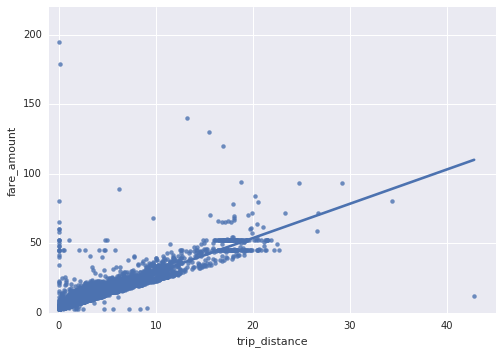

In [7]:
ax = sns.regplot(x="trip_distance", y="fare_amount", ci=None, truncate=True, data=trips)
ax.set(xlim=(-1,45))
ax.set(ylim=(-1, 220))

We have a few obvious ways to clear the data here. Firstly, we can notice two horizontal lines in the data; we assume that these are coming from some fixed and common toll price.

In [8]:
tollrides = trips[trips['tolls_amount'] > 0]
tollrides[tollrides['pickup_datetime'] == '2014-05-20 23:09:00'][5:]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
5298,2014-05-20 23:09:00,-73.783898,40.648660,-73.981845,40.762872,6,18.18,5.33,52.0,69.30
5402,2014-05-20 23:09:00,-73.781987,40.644755,-73.921672,40.828412,1,19.08,5.33,50.5,56.83
5854,2014-05-20 23:09:00,-73.873210,40.774042,-73.978013,40.755800,5,10.45,5.33,30.5,36.83
5855,2014-05-20 23:09:00,-73.870160,40.760742,-73.980912,40.788492,4,10.37,5.33,30.5,45.91
5861,2014-05-20 23:09:00,-73.874445,40.774037,-73.982382,40.784930,1,9.97,5.33,30.5,44.10
5873,2014-05-20 23:09:00,-73.984350,40.761760,-73.859030,40.718510,2,10.04,5.33,31.5,37.83
5896,2014-05-20 23:09:00,-73.874567,40.774102,-73.986480,40.759202,1,11.43,5.33,37.0,54.04
5919,2014-05-20 23:09:00,-74.011087,40.724797,-74.026347,40.750997,1,4.09,11.00,45.0,61.00


We can see some other issues with dirty data if we run `describe()` on the full dataset:

In [9]:
trips.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,10789.000000,10789.000000,10789.000000,10789.000000,10789.000000,10789.000000,10789.000000,10789.000000,10789.000000
mean,-72.577466,39.988518,-72.577056,39.991694,1.648716,2.837068,0.228359,11.165192,13.280564
std,10.071200,5.523964,10.068592,5.510504,1.282589,3.319036,1.144977,9.444876,11.267704
min,-75.336579,0.000000,-75.381754,0.000000,0.000000,0.000000,0.000000,2.500000,2.500000
25%,-73.992172,40.735837,-73.991581,40.734267,1.000000,1.010000,0.000000,6.000000,7.200000
50%,-73.981871,40.753200,-73.980401,40.752872,1.000000,1.750000,0.000000,8.500000,10.000000
75%,-73.967330,40.767309,-73.964102,40.767484,2.000000,3.110000,0.000000,12.500000,14.600000
max,0.000000,41.366138,0.000000,41.366138,6.000000,42.800000,16.000000,194.750000,204.750000


We now create a query to pull three clean datasets of different sizes, training test and validation. 

We remove all data for
- trips with zero distance
- fares below $2.50
- latitudes and longitudes outside New York City
- trips with zero passengers

And perform a `FARM_FINGERPRINT` sample followed by another hash to split the data. 

Note that we also remove the trip distance column as this depends on the route taken, which we do not have for new rows.

In [10]:
def sample_between(a, b):
    basequery = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers
FROM
  `nyc-tlc.yellow.trips`
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """
    sampler = "AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),EVERY_N) = 1"
    sampler2 = "AND {0} >= {1}\n AND {0} < {2}".format(
           "MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),EVERY_N*100)",
           "(EVERY_N*{})".format(a), "(EVERY_N*{})".format(b)
        )
    return "{}\n{}\n{}".format(basequery, sampler, sampler2)

def create_query(phase, EVERY_N):
  """phase: train (70%) valid (15%) or test (15%)"""
  query = ""
  if phase == 'train':
    # training
    query = sample_between(0, 70)
  elif phase == 'valid':
    query = sample_between(70, 85)
  else:
    query = sample_between(85, 100)
  return query.replace("EVERY_N", str(EVERY_N))

print create_query('train', 100000)


SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers
FROM
  `nyc-tlc.yellow.trips`
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  
AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),100000) = 1
AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),100000*100) >= (100000*0)
 AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),100000*100) < (100000*70)


Finally, we dump the three datasets to `.csv` files where we will use them later. 

In [12]:
def to_csv(df, filename):
  outdf = df.copy(deep=False)
  outdf.loc[:, 'key'] = np.arange(0, len(outdf)) # rownumber as key
  # reorder columns so that target is first column
  cols = outdf.columns.tolist()
  cols.remove('fare_amount')
  cols.insert(0, 'fare_amount')
  # print cols  # new order of columns
  outdf = outdf[cols]
  outdf.to_csv(filename, header=False, index_label=False, index=False)
  print "Wrote {} rows to {}".format(len(outdf), filename)

for phase in ['train', 'valid', 'test']:
  query = create_query(phase, 100000)
  df = bq.Query(query).execute().result().to_dataframe()
  to_csv(df, 'taxi-{}.csv'.format(phase))

Wrote 7645 rows to taxi-train.csv
Wrote 1814 rows to taxi-valid.csv
Wrote 1017 rows to taxi-test.csv


Throughout this exercise we will spend considerable time comparing between different models. So a good first step is to create a very simple "benchmark" model which will give us some initial goal. 

This problem has a fairly natural benchmark: we compute the "as the crow flies" distance between the start and drop-off points, and multiply it by the mean fare amount. 

In [13]:
def distance_between(lat1, lon1, lat2, lon2):
  # haversine formula to compute distance "as the crow flies".  Taxis can't fly of course.
  dist = np.degrees(np.arccos(np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1)))) * 60 * 1.515 * 1.609344
  return dist

def estimate_distance(df):
  return distance_between(df['pickuplat'], df['pickuplon'], df['dropofflat'], df['dropofflon'])

def compute_rmse(actual, predicted):
  return np.sqrt(np.mean((actual-predicted)**2))

def print_rmse(df, rate, name):
  print "{1} RMSE = {0}".format(compute_rmse(df['fare_amount'], rate*estimate_distance(df)), name)

FEATURES = ['pickuplon','pickuplat','dropofflon','dropofflat','passengers']
TARGET = 'fare_amount'
columns = list([TARGET])
columns.extend(FEATURES) # in CSV, target is the first column, after the features
columns.append('key')
df_train = pd.read_csv('taxi-train.csv', header=None, names=columns)
df_valid = pd.read_csv('taxi-valid.csv', header=None, names=columns)
df_test = pd.read_csv('taxi-test.csv', header=None, names=columns)
rate = df_train['fare_amount'].mean() / estimate_distance(df_train).mean()
print "Rate = ${0}/km".format(rate)
print_rmse(df_train, rate, 'Train')
print_rmse(df_valid, rate, 'Valid') 
print_rmse(df_test, rate, 'Test') 

Rate = $2.61647175325/km
Train RMSE = 7.45944982351
Valid RMSE = 9.35408256465
Test RMSE = 5.44470804972


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in arccos
  app.launch_new_instance()


So we have a benchmark RMSE: 9.35. 

Let's take the opportunity to plot a few rides on a map:

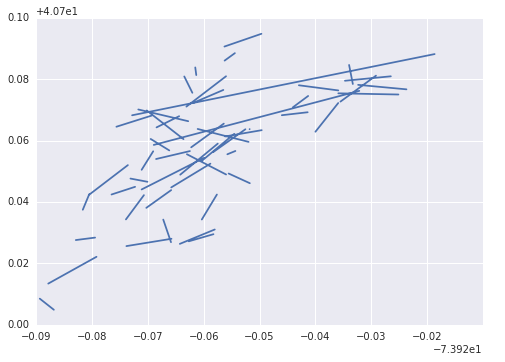

In [15]:
def showrides(df, numlines):
  import matplotlib.pyplot as plt
  lats = []
  lons = []
  goodrows = df[df['pickuplon'] < -70]
  for iter, row in goodrows[:numlines].iterrows():
    lons.append(row['pickuplon'])
    lons.append(row['dropofflon'])
    lons.append(None)
    lats.append(row['pickuplat'])
    lats.append(row['dropofflat'])
    lats.append(None)

  sns.set_style("darkgrid")
  plt.plot(lons, lats)
  
showrides(df_train, 50)

We can easily load our CSV files back into Pandas:

In [16]:
CSV_COLUMNS = ['fare_amount', 'pickuplon','pickuplat','dropofflon','dropofflat','passengers', 'key']
FEATURES = CSV_COLUMNS[1:len(CSV_COLUMNS)-1]
TARGET = CSV_COLUMNS[0]

df_train = pd.read_csv('taxi-train.csv', header=None, names=CSV_COLUMNS)
df_valid = pd.read_csv('taxi-valid.csv', header=None, names=CSV_COLUMNS)
print df_train.head()
print df_valid.head()

   fare_amount  pickuplon  pickuplat  dropofflon  dropofflat  passengers  key
0          2.5 -73.988954  40.758612  -73.952118   40.776227         2.0    0
1          2.5 -73.971783  40.763727  -73.971769   40.763768         2.0    1
2          3.0 -73.976258  40.786085  -73.974417   40.788517         2.0    2
3          3.0 -73.990085  40.746602  -73.993129   40.747650         2.0    3
4          3.5 -73.985820  40.744768  -73.978803   40.752505         2.0    4
   fare_amount  pickuplon  pickuplat  dropofflon  dropofflat  passengers  key
0          3.0 -74.009799  40.704862  -74.007660   40.707634         2.0    0
1          4.0 -73.956932  40.770882  -73.962624   40.762970         2.0    1
2          4.5 -73.997503  40.740958  -74.006575   40.741453         2.0    2
3          4.5 -73.992355  40.722983  -73.986278   40.729543         2.0    3
4          4.5 -73.990936  40.770157  -73.985336   40.778435         2.0    4


In order to make this data useable in Tensorflow, we need to convert the dataframes to tensors, and provide an "input function" which calls no parameters. 

In [17]:
def make_input_fn(df):
  def pandas_to_tf(pdcol):
    # convert the pandas column values to float
    t = tf.constant(pdcol.astype('float32').values)
    # take the column which is of shape (N) and make it (N, 1)
    return tf.expand_dims(t, -1)
  
  def input_fn():
    # create features, columns
    features = {k: pandas_to_tf(df[k]) for k in FEATURES}
    labels = tf.constant(df[TARGET].values)
    return features, labels
  return input_fn
  
def make_feature_cols():
  input_columns = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]
  return input_columns

We start with a simple Linear Regression model, using the most simple out-of-the-box implementation that Tensorflow has.

In [22]:
tf.logging.set_verbosity(tf.logging.INFO)
shutil.rmtree('taxi_trained', ignore_errors=True) # Start fresh each time by clearing the directory
model = tf.contrib.learn.LinearRegressor(
      feature_columns=make_feature_cols(), model_dir='taxi_trained')
model.fit(input_fn=make_input_fn(df_train), steps=10);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efe50d7f0d0>, '_model_dir': 'taxi_trained', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create Che

In [23]:
def print_rmse(model, name, input_fn):
  metrics = model.evaluate(input_fn=input_fn, steps=1)
  print 'RMSE on {} dataset = {}'.format(name, np.sqrt(metrics['loss']))
print_rmse(model, 'validation', make_input_fn(df_valid))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-12-03-17:26:08
INFO:tensorflow:Restoring parameters from taxi_trained/model.ckpt-10
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-03-17:26:09
INFO:tensorflow:Saving dict for global step 10: global_step = 10, loss = 102.479
RMSE on validation dataset = 10.123175621


In [7]:

# read saved model and use it for prediction
model = tf.contrib.learn.LinearRegressor(
      feature_columns=make_feature_cols(), model_dir='taxi_trained')
preds_iter = model.predict(input_fn=make_input_fn(df_valid))
print list(itertools.islice(preds_iter, 5)) # first 5

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2cd1e5a390>, '_model_dir': 'taxi_trained', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
INFO:tensorflow:Restoring parameters from taxi_trained/model.ckpt-10
[11.348775, 11.349922, 11.351535, 11.348835, 11.353409]


In [9]:
tf.logging.set_verbosity(tf.logging.INFO)
shutil.rmtree('taxi_trained', ignore_errors=True) # start fresh each time
model = tf.contrib.learn.DNNRegressor(hidden_units=[32, 8, 2],
      feature_columns=make_feature_cols(), model_dir='taxi_trained')
model.fit(input_fn=make_input_fn(df_train), steps=1000);
print_rmse(model, 'validation', make_input_fn(df_valid))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2cd0888c90>, '_model_dir': 'taxi_trained', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create Che

In [10]:


def create_query(phase, EVERY_N):
  """
  phase: 1=train 2=valid
  """
  base_query = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key,
  DAYOFWEEK(pickup_datetime)*1.0 AS dayofweek,
  HOUR(pickup_datetime)*1.0 AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """

  if EVERY_N == None:
    if phase < 2:
      # training
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 < 2".format(base_query)
    else:
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 == {1}".format(base_query, phase)
  else:
      query = "{0} AND ABS(HASH(pickup_datetime)) % {1} == {2}".format(base_query, EVERY_N, phase)
    
  return query



query = create_query(2, 100000)
df = bq.Query(query).to_dataframe()
print_rmse(model, 'benchmark', make_input_fn(df))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-12-03-13:44:02
INFO:tensorflow:Restoring parameters from taxi_trained/model.ckpt-1000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-03-13:44:02
INFO:tensorflow:Saving dict for global step 1000: global_step = 1000, loss = 159.389
RMSE on benchmark dataset = 12.6249237061


# Batched

In [23]:
CSV_COLUMNS = ['fare_amount', 'pickuplon','pickuplat','dropofflon','dropofflat','passengers', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [[0.0], [-74.0], [40.0], [-74.0], [40.7], [1.0], ['nokey']]

def read_dataset(filename, num_epochs=None, batch_size=512, mode=tf.contrib.learn.ModeKeys.TRAIN):
  def _input_fn():
    filename_queue = tf.train.string_input_producer(
        [filename], num_epochs=num_epochs, shuffle=True)
    reader = tf.TextLineReader()
    _, value = reader.read_up_to(filename_queue, num_records=batch_size)

    value_column = tf.expand_dims(value, -1)
    columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)
    features = dict(zip(CSV_COLUMNS, columns))
    label = features.pop(LABEL_COLUMN)
    return features, label

  return _input_fn

def get_train():
  return read_dataset('taxi-train.csv', num_epochs=1000, mode=tf.contrib.learn.ModeKeys.TRAIN)

def get_valid():
  return read_dataset('taxi-valid.csv', num_epochs=1, mode=tf.contrib.learn.ModeKeys.EVAL)

def get_test():
  return read_dataset('taxi-test.csv', num_epochs=1, mode=tf.contrib.learn.ModeKeys.EVAL)

In [17]:

LABEL_COLUMN = 'fare_amount'
INPUT_COLUMNS = [
    layers.real_valued_column('pickuplon'),
    layers.real_valued_column('pickuplat'),
    layers.real_valued_column('dropofflat'),
    layers.real_valued_column('dropofflon'),
    layers.real_valued_column('passengers'),
]

feature_cols = INPUT_COLUMNS
tf.logging.set_verbosity(tf.logging.INFO)
shutil.rmtree('taxi_trained', ignore_errors=True) # start fresh each time
model = tf.contrib.learn.LinearRegressor(
      feature_columns=feature_cols, model_dir='taxi_trained')
model.fit(input_fn=get_train())
def print_rmse(model, name, input_fn):
  metrics = model.evaluate(input_fn=input_fn, steps=1)
  print 'RMSE on {} dataset = {}'.format(name, np.sqrt(metrics['loss']))
print_rmse(model, 'validation', get_valid())

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2cc409fb50>, '_model_dir': 'taxi_trained', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create Che

In [24]:

def experiment_fn(output_dir):
    return tflearn.Experiment(
        tflearn.LinearRegressor(feature_columns=feature_cols, model_dir=output_dir),
        train_input_fn=get_train(),
        eval_input_fn=get_valid(),
        eval_metrics={
            'rmse': tflearn.MetricSpec(
                metric_fn=metrics.streaming_root_mean_squared_error
            )
        }
    )


shutil.rmtree('taxi_trained', ignore_errors=True) # start fresh each time
learn_runner.run(experiment_fn, 'taxi_trained')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2cc44c1d50>, '_model_dir': 'taxi_trained', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor o

({'global_step': 15000, 'loss': 96.119095, 'rmse': 10.120475}, [])

In [26]:
TensorBoard().start('./taxi_trained')
TensorBoard().list()

TensorBoard was started successfully with pid 7785. Click here to access it.

,logdir,pid,port
0,./taxi_trained,7780,51887
1,./taxi_trained,7785,58640


# Scaling up to CloudML Engine

In [7]:
import tensorflow as tf
import os
PROJECT = 'qwiklabs-gcp-d96269c75247225c'
BUCKET = 'clinton-datalab'
REGION = 'us-central1'
REPO = os.getcwd()
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['REPO'] = REPO

In [8]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [9]:
%bash
PROJECT_ID=$PROJECT
AUTH_TOKEN=$(gcloud auth print-access-token)
SVC_ACCOUNT=$(curl -X GET -H "Content-Type: application/json" \
    -H "Authorization: Bearer $AUTH_TOKEN" \
    https://ml.googleapis.com/v1/projects/${PROJECT_ID}:getConfig \
    | python -c "import json; import sys; response = json.load(sys.stdin); \
    print response['serviceAccount']")

echo "Authorizing the Cloud ML Service account $SVC_ACCOUNT to access files in $BUCKET"
gsutil -m defacl ch -u $SVC_ACCOUNT:R gs://$BUCKET
gsutil -m acl ch -u $SVC_ACCOUNT:R -r gs://$BUCKET  # error message (if bucket is empty) can be ignored
gsutil -m acl ch -u $SVC_ACCOUNT:W gs://$BUCKET

Authorizing the Cloud ML Service account service-69551556079@cloud-ml.google.com.iam.gserviceaccount.com to access files in clinton-datalab


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   133    0   133    0     0    302      0 --:--:-- --:--:-- --:--:--   302
Updated default ACL on gs://clinton-datalab/
Encountered a problem: CommandException: No URLs matched: gs://clinton-datalab/*
Updated ACL on gs://clinton-datalab/


In [11]:
!find taxifare

taxifare
taxifare/trainer
taxifare/trainer/__init__.py
taxifare/trainer/model.py
taxifare/trainer/task.py


In [13]:
%bash
rm -rf taxifare.tar.gz taxi_trained
export PYTHONPATH=${PYTHONPATH}:${REPO}/taxifare
python -m trainer.task \
   --train_data_paths="${REPO}/taxi-train*" \
   --eval_data_paths=${REPO}/taxi-valid.csv  \
   --output_dir=${REPO}/taxi_trained \
   --num_epochs=10 --job-dir=./tmp

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4d63a54dd0>, '_model_dir': '/content/datalab/notebooks/taxi/taxi_trained/', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are cre

In [15]:
!ls -l $REPO/taxi_trained/export/Servo

total 4
drwxr-xr-x 3 root root 4096 Dec  4 08:26 1512376013


In [18]:
%writefile ./test.json
{"pickuplon": -73.885262,"pickuplat": 40.773008,"dropofflon": -73.987232,"dropofflat": 41.732403,"passengers": 2}

Overwriting ./test.json


In [19]:
%bash
model_dir=$(ls ${REPO}/taxi_trained/export/Servo)
gcloud ml-engine local predict \
    --model-dir=${REPO}/taxi_trained/export/Servo/${model_dir} \
    --json-instances=./test.json

SCORES
11.1427


2017-12-04 08:31:27.937648: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-04 08:31:27.937659: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-12-04 08:31:27.937669: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-04 08:31:27.937679: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use FMA instructions, but these are available on your machine and could speed up CPU computations.



In [28]:
%bash
rm -rf taxifare.tar.gz taxi_trained
gcloud ml-engine local train \
   --module-name=trainer.task \
   --package-path=${REPO}/taxifare/trainer \
   -- \
   --train_data_paths=${REPO}/taxi-train.csv \
   --eval_data_paths=${REPO}/taxi-valid.csv  \
   --num_epochs=20 \
   --output_dir=${REPO}/taxi_trained 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f41bf8de450>, '_model_dir': '/content/datalab/notebooks/taxi/taxi_trained/', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': u'cloud', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are cr

In [29]:
%bash
echo $BUCKET
gsutil -m rm -rf gs://${BUCKET}/taxifare/smallinput/
gsutil -m cp ${REPO}/*.csv gs://${BUCKET}/taxifare/smallinput/

clinton-datalab


CommandException: 1 files/objects could not be removed.
Copying file:///content/datalab/notebooks/taxi/taxi-test.csv [Content-Type=text/csv]...
Copying file:///content/datalab/notebooks/taxi/taxi-train.csv [Content-Type=text/csv]...
Copying file:///content/datalab/notebooks/taxi/taxi-valid.csv [Content-Type=text/csv]...
/ [3/3 files][568.8 KiB/568.8 KiB] 100% Done                                    
Operation completed over 3 objects/568.8 KiB.                                    


In [30]:
%%bash
OUTDIR=gs://${BUCKET}/taxifare/smallinput/taxi_trained
JOBNAME=lab3a_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${REPO}/taxifare/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC \
   --runtime-version=1.0 \
   -- \
   --train_data_paths="gs://${BUCKET}/taxifare/smallinput/taxi-train*" \
   --eval_data_paths="gs://${BUCKET}/taxifare/smallinput/taxi-valid*"  \
   --output_dir=$OUTDIR \
   --num_epochs=100

gs://clinton-datalab/taxifare/smallinput/taxi_trained us-central1 lab3a_171204_083636
jobId: lab3a_171204_083636
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [lab3a_171204_083636] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe lab3a_171204_083636

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs lab3a_171204_083636


## Predict

In [32]:
%bash
gsutil ls gs://${BUCKET}/taxifare/smallinput/taxi_trained/export/Servo

gs://clinton-datalab/taxifare/smallinput/taxi_trained/export/Servo/
gs://clinton-datalab/taxifare/smallinput/taxi_trained/export/Servo/1512377338807/


In [34]:
%bash
MODEL_NAME="taxifare"
MODEL_VERSION="v1"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/taxifare/smallinput/taxi_trained/export/Servo | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION}

Deleting and deploying taxifare v1 from gs://clinton-datalab/taxifare/smallinput/taxi_trained/export/Servo/1512377338807/ ... this will take a few minutes


ERROR: (gcloud.ml-engine.models.create) Resource in project [qwiklabs-gcp-d96269c75247225c] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name
ERROR: (gcloud.ml-engine.versions.create) ALREADY_EXISTS: Field: version.name Error: A version with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A version with the same name already exists.
    field: version.name


In [36]:
%bash
gcloud ml-engine predict --model=taxifare --version=v1 --json-instances=./test.json

OUTPUTS
3.20257


In [38]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials,
            discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1_discovery.json')

request_data = {'instances':
  [
      {
        'pickuplon': -73.885262,
        'pickuplat': 40.773008,
        'dropofflon': -73.987232,
        'dropofflat': 40.732403,
        'passengers': 2,
      }
  ]
}

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, 'taxifare', 'v1')
response = api.projects().predict(body=request_data, name=parent).execute()
print "response={0}".format(response)

response={u'predictions': [{u'outputs': 3.2025725841522217}]}
